In [1]:
import copy

import pandas as pd
import sys
import math

sys.path.append('../../')
from Algorithms import GlobalBounds as globalbounds

import numpy as np
import copy
import sys
import math
from sklearn.linear_model import LinearRegression
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from Algorithms import PropBounds as propbounds

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['font.size'] = '22'

sns.set_palette("Paired")
# sns.set_palette("deep")
sns.set_context("poster", font_scale=2)
sns.set_style("whitegrid")
# sns.palplot(sns.color_palette("deep", 10))
# sns.palplot(sns.color_palette("Paired", 9))

line_style = ['o-', 's--', '^:', '-.p']
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
# plt_title = ["BlueNile", "COMPAS", "Credit Card"]
#
# label = ["PropBounds", "IterTD"]
line_width = 8
marker_size = 20
f_size = (18, 16)
FONTSIZE=50

In [2]:
def string2list(st):
    p = list()
    idx = 0
    item = ''
    i = ''
    for i in st:
        if i == '|':
            if item == '':
                p.append(-1)
            else:
                if item.isnumeric():
                    p.append(int(item))
                else:
                    p.append(item)
                item = ''
            idx += 1
        else:
            item += i
    if i != '|':
        if item.isnumeric():
            p.append(int(item))
        else:
            p.append(item)
    else:
        p.append(-1)
    return p


def P1DominatedByP2(P1, P2):
    length = len(P1)
    for i in range(length):
        if P1[i] == -1:
            if P2[i] != -1:
                return False
        if P1[i] != -1:
            if P2[i] != P1[i] and P2[i] != -1:
                return False
    return True

def idx_of_tuples_in_group(group, data):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            return True
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    return data[data["in"] == True].index

def average_shapley_values_of_group(data, group, all_attributes, shap_values):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    tuples_idx = idx_of_tuples_in_group(group, data1).to_list()
    if len(tuples_idx) == 0:
        # output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        print("group {} size {}".format(group, len(tuples_idx)))
        return []
    else:
        avg = np.average(shap_values.values[tuples_idx], axis=0)
        print("group {} size {}".format(group, len(tuples_idx)))
        # print(avg)
        return list(avg)


def idx_of_tuples_in_group_w_attribute(group, data, att, value):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            if row[att] == value:
                return True
            else:
                return False
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    idx = data[data["in"] == True].index
    data.drop(columns=["in"], axis=1, inplace=True)
    return idx


def shapley_values_att_value_seperated(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    att_idx = 0
    for att in all_attributes:
        for v in range(int(data1.describe()[att]["min"]), int(data1.describe()[att]["max"]) + 1):
            tuples_idx = idx_of_tuples_in_group_w_attribute(group, data1, att, v).to_list()
            if len(tuples_idx) == 0:
                output_file.write("group {} att {} = {} size {}\n".format(group, att, v, len(tuples_idx)))
                print("group {} att {} = {} size {}".format(group, att, v, len(tuples_idx)))
            else:
                values_of_group = shap_values.values[tuples_idx]
                avg = np.average(values_of_group, axis=0)
                print("group {} att {} = {} size {}\n avg {}".format(group, att, v, len(tuples_idx), avg))
                output_file.write("group {} att {} = {} size {} avg {}\n".format(group, att, v, len(tuples_idx), avg[att_idx]))
        att_idx += 1

def tuples_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    tuples = data.iloc[tuple_idx]
    return tuples

def tuples_not_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    return data.drop(tuple_idx)

# def check_another_group_global_bounds(g, data, selected_attributes, thc, Lowerbounds, k):
#     size_whole_data = len(tuples_in_group(g, data, selected_attributes))
#     if size_whole_data < thc:
#         print("group g size too small", size_whole_data)
#         return False
#     size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
#     if size_topk < Lowerbounds[0]:
#         print("group g doesn't have enough representation in top k", size_topk)
#         return False
#     return True


# def check_another_group_prop_bounds(g, data, selected_attributes, thc, alpha, k):
#     size_whole_data = len(tuples_in_group(g, data, selected_attributes))
#     if size_whole_data < thc:
#         print("group g size too small", size_whole_data)
#         return False
#     size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
#     lowerbound = alpha * size_whole_data * k / len(data)
#     print(size_whole_data, size_topk, lowerbound)
#     if size_topk < lowerbound:
#         print("group g doesn't have enough representation in top k", size_topk)
#         return False
#     return True


# def plot_distribution_number(ranked_data, attribute, group, another_group, k):
#     x_list = ranked_data[attribute].unique()
#     x_list.sort()
#     tuples = tuples_in_group(group, ranked_data, selected_attributes)
#     s = tuples[attribute].value_counts().sort_index()
#     group_value_dis = [s[i] if i in s else 0 for i in x_list]
#     s = ranked_data[attribute].value_counts().sort_index()
#     whole_data_dis = [s[i] if i in s else 0 for i in x_list]
#     s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
#     other_data_dis = [s[i] if i in s else 0 for i in x_list]
#     s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
#     total = sum(s)
#     another_group_dis = [s[i] if i in s else 0 for i in x_list]
#
#
#     s = ranked_data[:k][attribute].value_counts().sort_index()
#     topkdis = [s[i] if i in s else 0 for i in x_list]
#
#     index = np.arange(len(x_list))
#     bar_width = 0.2
#
#     fig, ax = plt.subplots(1, 1, figsize=(20, 8))
#
#     index = np.arange(len(x_list))
#     plt.bar(index, group_value_dis, bar_width, color=color[0], label="group")
#     plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
#     plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
#     plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="non-problematic group")
#     plt.bar(index + bar_width * 4, topkdis, bar_width,  color=color[8], label="topk")
#     # plt.xticks(index + bar_width, x_list)
#     # plt.xticks(index, x_list)
#
#     plt.ylabel('number of tuples')
#     plt.xlabel('value of attribute ' + attribute)
#     # plt.yscale('log')
#     plt.legend(loc='best', fontsize=25)
#
#     plt.tight_layout()
#     # plt.savefig("adult_time.png", bbox_inches='tight')
#     plt.show()



In [19]:

def plot_distribution_ratio(ranked_data, attribute, original_att, group, group_name, k, axis):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    print("unique values of {} = {}".format(attribute, x_list))

    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    print("num of tuples in group {} = {}".format(len(tuples), group))
    s = tuples[attribute].value_counts().sort_index()
    total = sum(s)
    group_value_dis = [s[i]/total if i in s else 0 for i in x_list]

    s = ranked_data[:k][attribute].value_counts().sort_index()
    total = sum(s)
    topkdis = [s[i]/total if i in s else 0 for i in x_list]

    bar_width = 0.45
    index = np.arange(len(x_list))
    print(index)
    axis.bar(index, group_value_dis, bar_width, color=color[3], label=group_name)
    axis.bar(index + bar_width, topkdis, bar_width,  color=color[7], label="top-k")
    # plt.xticks(index + bar_width, x_list)
    # plt.xticks(range(x_list[0], x_list[-1]+1))
    index2 = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
    axis.set_xticks([x + bar_width/2 for x in index2], [0, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize=FONTSIZE)
    axis.set_yticks([0, 0.1, 0.2, 0.3], [0, 0.1, 0.2, 0.3], fontsize=FONTSIZE)
    axis.set_ylabel('Proportion', fontsize=FONTSIZE)
    axis.set_xlabel('Value of '+ original_att, fontsize=FONTSIZE)
    axis.legend(loc='upper left', fontsize=40, bbox_to_anchor=(-0.02, 1.04))
    # plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    # plt.show()
    return axis


In [4]:

def plot_average_shap_value_of_group(data, group, selected_attributes, all_attributes_original, shap_values, axis):
    s = average_shapley_values_of_group(data, group, selected_attributes, shap_values)
    df=pd.DataFrame({'Attribute':all_attributes_original, 'Shapley values':s})

    df.sort_values(by='Shapley values',key=abs, inplace=True,ascending=False)

    small_shap_values = df[6:]
    summary_shap_values = df[:6]

    summary_shap_values = summary_shap_values.append({'Attribute': 'other positive Shapley values', 'Shapley values': sum([x if x > 0 else 0 for x in small_shap_values['Shapley values']])}, ignore_index=True)
    summary_shap_values = summary_shap_values.append({'Attribute': 'other negative Shapley values', 'Shapley values': sum([x if x < 0 else 0 for x in small_shap_values['Shapley values']])}, ignore_index=True)

    print(summary_shap_values)

    summary_shap_values = summary_shap_values[::-1]
    # summary_shap_values.plot(kind='barh',x='Attribute',y='Shapley values',color=[color[4] if t > 0 else color[0] for t in summary_shap_values['Shapley values']], figsize=(18, 16), legend=False, fontsize=FONTSIZE, ax=axis)
    summary_shap_values.plot(kind='barh',x='Attribute',y='Shapley values',color=[color[4] if t > 0 else color[0] for t in summary_shap_values['Shapley values']], legend=False, fontsize=FONTSIZE, ax=axis)
    axis.set_ylabel('Attribute', fontsize=FONTSIZE)
    # plt.show()
    # plt.xlabel('Shapley values', fontsize=FONTSIZE)
    # plt.ylabel('Attribute', fontsize=FONTSIZE)
    # plt.tight_layout()
    # fig.set(xlabel='Shapley values')
    # return plt



# student data

In [5]:
all_attributes = ['school_C', 'sex_C', 'age_C', 'address_C', 'famsize_C', 'Pstatus_C', 'Medu_C',
                      'Fedu_C', 'Mjob_C', 'Fjob_C', 'reason_C', 'guardian_C', 'traveltime_C', 'studytime_C',
                      'failures_C', 'schoolsup_C', 'famsup_C', 'paid_C', 'activities_C', 'nursery_C', 'higher_C',
                      'internet_C', 'romantic_C', 'famrel_C', 'freetime_C', 'goout_C', 'Dalc_C', 'Walc_C',
                      'health_C', 'absences_C', 'G1_C', 'G2_C', 'G3_C']

all_attributes_original = ['student\'s school', 'student\'s sex', 'student\'s age',
                  'student\'s home address type', 'family size', 'parent\'s cohabitation status',
                  'mother\'s education', 'father\'s education', 'mother\'s job',
                  'father\'s job', 'reason to choose this school', 'student\'s guardian',
                  'home to school travel time', 'weekly study time', 'number of past class failures',
                  'extra educational support', 'family educational support', 'extra paid classes within the course subject',
                  'extra-curricular activities', 'attended nursery school', 'wants to take higher education',
                  'Internet access at home', 'with a romantic relationship', 'quality of family relationships',
                  'free time after school', 'going out with friends', 'workday alcohol consumption',
                  'weekend alcohol consumption', 'current health status', 'number of school absences',
                  'first period grade', 'second period grade', 'final grade']


original_data_file = r"../../../InputData/StudentDataset/ForRanking_1/student-mat_cat_ranked.csv"

ranked_data = pd.read_csv(original_data_file, index_col=False)


# 16 att

In [7]:

selected_attributes = all_attributes[:16]

k = 49
k_min = k
k_max = k
thc = 50
Lowerbounds = [20]
time_limit = 5*60
result_global_bounds, num_patterns_visited1_, t1_ \
    = globalbounds.GraphTraverse(
    ranked_data[selected_attributes].copy(deep=True), selected_attributes, thc,
    Lowerbounds,
    k_min, k_max, time_limit)
# print(result_global_bounds)
groups_global_bounds = [string2list(s) for s in list(result_global_bounds[0])]
print(len(groups_global_bounds))
for g in groups_global_bounds:
    print(g)


68
[-1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 'services', -1, -1, -1, -1, -1, -1]
[-1, 'M', -1, -1, 'GT3', 'T', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, 'M', -1, 'U', -1, 'T', -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
[-1, 'M', 1, -1, -1, 'T', -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
[-1, 'M', -1, -1, 'GT3', -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1]
[-1, -1, -1, -1, 'GT3', -1, -1, -1, -1, -1, -1, 'mother', 1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'yes']
[-1, -1, -1, -1, 'GT3', 'T', -1, -1, -1, -1, -1, 'mother', -1, -1, 0, -1]
[-1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, 'F', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 1, -1, -1, 'T', -1, -1, -1, -1, -1, 'mother', 1, -1, -1, -1]
[-1, 'M', -1, -1, -1, -1, -1, -1, -1, -1, -1, 'mother', 1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 'ot

In [8]:
selected_attributes = all_attributes[:16]

alpha = 0.8
k = 49
k_min = k
k_max = k
thc = 50
time_limit = 5*60
result_prop_bounds, num_patterns_visited1_, t1_ \
            = propbounds.GraphTraverse(
            ranked_data[selected_attributes], selected_attributes, thc,
            alpha,
            k_min, k_max, time_limit)
groups_prop_bounds = [string2list(k) for k in list(result_prop_bounds[0])]
for g in groups_prop_bounds:
    print(g)


[-1, -1, -1, -1, 'GT3', 'T', -1, -1, -1, -1, -1, -1, -1, 3, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'yes']
[-1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, 'F', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, 'mother', -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
['GP', -1, 1, 'U', 'LE3', 'T', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 'other', -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 'R', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, 'T', -1, 2, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'course', -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1]
[

In [9]:

x = ranked_data[all_attributes]
y = ranked_data['rank']
# have to convert strings to numbers for linear regression
def convert_string_to_number(df, all_attributes):
    col_idx = 0
    def convert_to_number(column):
        nonlocal col_idx
        if column.dtypes == 'object':
            unique_values = sorted(column.unique())
            print(all_attributes[col_idx], unique_values)
            df[all_attributes[col_idx]].replace(to_replace=unique_values,
                              value=range(1, len(unique_values)+1), inplace=True)
        col_idx += 1
    df.apply(convert_to_number, axis=0)
    return df

x = convert_string_to_number(x, all_attributes)


# with sklearn
model = LinearRegression()
model.fit(x, y)
print("Model coefficients:\n")
for i in range(x.shape[1]):
    print(x.columns[i], "=", model.coef_[i].round(5))
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, x)
shap_values = explainer(x)
shap_values


school_C ['GP', 'MS']
sex_C ['F', 'M']
address_C ['R', 'U']
famsize_C ['GT3', 'LE3']
Pstatus_C ['A', 'T']
Mjob_C ['at_home', 'health', 'other', 'services', 'teacher']
Fjob_C ['at_home', 'health', 'other', 'services', 'teacher']
reason_C ['course', 'home', 'other', 'reputation']
guardian_C ['father', 'mother', 'other']
schoolsup_C ['no', 'yes']
famsup_C ['no', 'yes']
paid_C ['no', 'yes']
activities_C ['no', 'yes']
nursery_C ['no', 'yes']
higher_C ['no', 'yes']
internet_C ['no', 'yes']
romantic_C ['no', 'yes']
Model coefficients:

school_C = 11.89275
sex_C = -5.39896
age_C = 16.187
address_C = -13.22364
famsize_C = 0.0323
Pstatus_C = -4.06843
Medu_C = -4.81818
Fedu_C = -0.6633
Mjob_C = 4.76802
Fjob_C = 2.47179
reason_C = -2.23184
guardian_C = 2.25619
traveltime_C = -4.56083
studytime_C = -0.81082
failures_C = -2.19889
schoolsup_C = 11.24251
famsup_C = 6.9722
paid_C = -7.03452
activities_C = -5.25613
nursery_C = 3.49264
higher_C = 8.5865
internet_C = -2.1814
romantic_C = 2.70547
famrel_C 

Permutation explainer: 396it [00:15, 12.49it/s]                         


.values =
array([[  -2.37854968,   -2.80745737,   -4.6942308 , ...,  -40.33274051,
         -27.89073168, -134.85165097],
       [  -2.37854968,   -2.80745737,   -4.6942308 , ...,  -40.33274051,
         -27.89073168, -134.85165097],
       [  -2.37854968,   -2.80745737,   -4.6942308 , ...,  -40.33274051,
         -27.89073168, -134.85165097],
       ...,
       [   9.51419873,   -2.80745737,   11.49277195, ...,   16.07668678,
          11.67058985,  148.0539105 ],
       [   9.51419873,    2.59149911,   11.49277195, ...,   16.07668678,
          11.67058985,  148.0539105 ],
       [   9.51419873,    2.59149911,   11.49277195, ...,   16.07668678,
          11.67058985,  148.0539105 ]])

.base_values =
array([193.8078427, 193.8078427, 193.8078427, 193.8078427, 193.8078427,
       193.8078427, 193.8078427, 193.8078427, 193.8078427, 193.8078427,
       193.8078427, 193.8078427, 193.8078427, 193.8078427, 193.8078427,
       193.8078427, 193.8078427, 193.8078427, 193.8078427, 193.8078427,
 

group [-1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1] size 103
                       Attribute  Shapley values
0                    final grade       13.467770
1             mother's education        4.191816
2            second period grade        2.260373
3               student's school       -1.570305
4                   mother's job       -0.886481
5     family educational support       -0.745281
6  other positive Shapley values        3.309257
7  other negative Shapley values       -2.157086


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


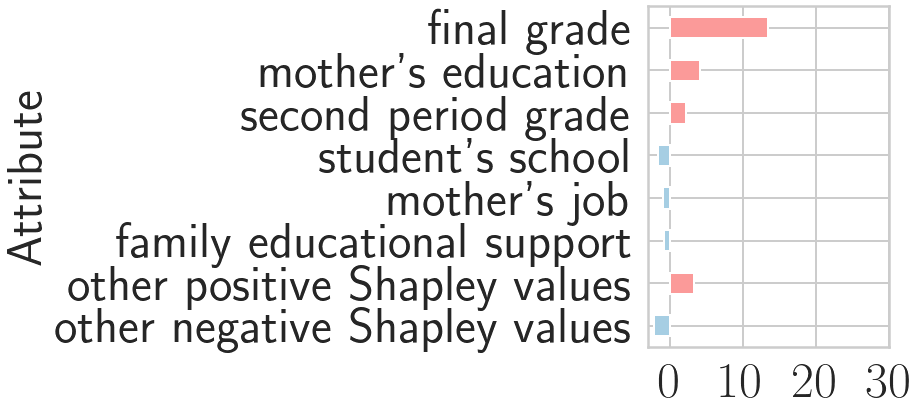

In [22]:
fig, ax = plt.subplots(1, 1,figsize=(14, 7))

group = groups_global_bounds[10]
plot_average_shap_value_of_group(ranked_data, group, selected_attributes, all_attributes_original, shap_values, ax)
plt.xticks([0, 10, 20, 30], fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig(r"student_shap_globalbounds.png", bbox_inches='tight')

unique values of G3 = [ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
num of tuples in group 103 = [-1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


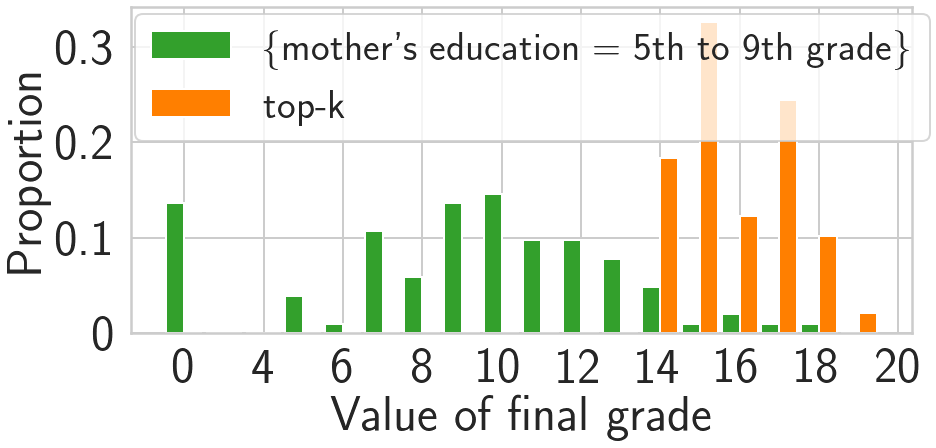

In [24]:
fig, ax = plt.subplots(1, 1,figsize=(14, 6))
original_att = 'final grade'
att = all_attributes[all_attributes_original.index(original_att)]
group_name = "\{mother's education = 5th to 9th grade\}"
plot_distribution_ratio(ranked_data, 'G3', original_att, group, group_name, k, ax)
# plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], fontsize=FONTSIZE)
fig.show()
plt.savefig(r"student_value_dis_globalbounds.png", bbox_inches='tight')
